In [1]:
'''This repository contains a detailed implementation of the Reinforcement Learning Enviroment class'''
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import *
import torch as T
from typing import Any, Callable, Dict, List, Tuple, Union, Optional
import scipy.integrate as integrate
T.Tensor.ndim = property(lambda self: len(self.shape))
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
from EnforceTyping import EnforceClassTyping, EnforceMethodTyping
from ParticlesandFields import Particle, Field
from Environment import Environment

**Vector Field**

In [2]:
@dataclass(kw_only= True)
class ElectricField(Field):
  FieldSources: Dict

  def __call__(self, ObservationPosition: T.Tensor)->T.Tensor:
      return self.FieldStrength(ObservationPosition)
  @EnforceMethodTyping
  def FieldStrength(self, ObservationPosition: T.Tensor)->T.Tensor:
    'This function takes a list of sources and outputs the field strength experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
    CoulombConstant = 8.9875e9 #N*m^2/C^2
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, Particle),  "The FieldSource is not a Particle"
    ElectricFieldVector = T.zeros_like(ObservationPosition)
    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      PositionMatrices= T.stack([T.ones_like(ObservationPosition[0])* SourcePosition[0].item(), 
                                T.ones_like(ObservationPosition[1])* SourcePosition[1].item()])
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = T.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
      ElectricFieldVector += (DisplacementVector * FieldSource.Charge) / DisplacementMagnitude**2
    return CoulombConstant * ElectricFieldVector #N/C or V/m
  @EnforceMethodTyping
  def FieldPotential(self, InitialPosition: T.Tensor, FinalPosition: T.Tensor, resolution: int= 5000)-> float:
      '''This method determines the amount of work required to get one position to another in the field'''
      XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
      YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
      XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
      YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
      WorkDone = 0
      for i in range(resolution):
          PositionFieldStrength = self.FieldStrength(T.Tensor([XPositions[i], YPositions[i]]))
          WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
      return WorkDone
  @EnforceMethodTyping
  def PlotField(self):
      'This funtion plots the 2D electric vector field'
      ObservationPosition= T.meshgrid(T.linspace(self.FieldLowBound, self.FieldHighBound, 50), 
                                      T.linspace(self.FieldLowBound, self.FieldHighBound, 50))
      ObservationPosition= T.stack(ObservationPosition)
      xd, yd = self.ElectricFieldStrength(ObservationPosition)
      xd = xd / T.sqrt(xd**2 + yd**2)
      yd = yd / T.sqrt(xd**2 + yd**2)
      color_aara = T.sqrt(xd**2+ yd**2)
      fig, ax = plt.subplots(1,1)
      cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
      fig.colorbar(cp)
      plt.rcParams['figure.dpi'] = 250
      plt.show()
  def Derivative(self, ObservationPosition):
    'This function returns the derivative of the field at a given point'
    CoulombConstant = 8.9875e9 #N*m^2/C^2
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, Particle),  "The FieldSource is not a Particle"
    ElectricFieldVector = T.zeros_like(ObservationPosition)
    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      PositionMatrices= T.stack([T.ones_like(ObservationPosition[0])* SourcePosition[0].item(), 
                                T.ones_like(ObservationPosition[1])* SourcePosition[1].item()])
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = T.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
      ElectricFieldVector += (DisplacementVector * FieldSource.Charge) / DisplacementMagnitude**1.5
    return -CoulombConstant * ElectricFieldVector


**Example 1: Particle in Field Environment**

In [3]:
@dataclass(kw_only=True)
class ParticleInField(Environment): 
  Field: Field
  ChargedParticle: Particle
  Target: T.Tensor
  DistanceWeight: float= 1.0
  EnergyWeight: float= -1.0
  TerminalSignalWeight: float= -1000.0
  CurrentTime: float = 0.0# s
  @dataclass 
  class State(EnforceClassTyping):
    '''This class represents the state of the Agent with its Position, Velocity and the Field Strength if experiences at its Position. 
    These are parameters the agent is able to observe, they uniquely define the state of the agent.'''
    Position: T.Tensor # m
    Velocity: T.Tensor #kg*m/s
    
    def Vector(self):
      return T.cat([self.Position, self.Velocity])
  InitialState: State = None
  CurrentState: State = None
  def __post_init__(self):
    if self.InitialState is None:
        self.InitialState= self.RandomState()
    self.CurrentState= self.InitialState

  def StateDynamics(self, State: T.Tensor, Time: float, ControlForce: T.Tensor):
    dxPosition, dyPosition = State[2], State[3]
    Position= T.tensor([State[0], State[1]])
    dxVelocity, dyVelocity = ((self.ChargedParticle.Charge* self.Field(Position))+ControlForce)/self.ChargedParticle.Mass

    return np.array([dxPosition, dyPosition, dxVelocity, dyVelocity])
  
  @EnforceMethodTyping
  def TransitionModel(self, State: State, Action: T.Tensor= T.tensor([0.0, 0.0]), TimeInterval:float= 1.0)-> State:
    '''Outputs the state of the system after taking an action(applying a constant force for *TimeInterval* seconds)'''
    Posx, Posy, Velx, Vely= integrate.odeint(self.StateDynamics, State.Vector(), [self.CurrentTime, self.CurrentTime+ TimeInterval], args=(Action,))[-1]
    CurrrentPosition= T.tensor([Posx, Posy])
    CurrentVelocity= T.tensor([Velx, Vely])
    return self.State(CurrrentPosition, CurrentVelocity)
  
  def RewardModel(self, State: State, Action: T.Tensor, NextState: State, TerminalSignal: bool)-> float:
      '''This method determines how the agent is rewarded given a state transition. The reward determines the behaviour the agent should learn(i.e getting to the target and using the least amount of energy).'''
      DistanceGainedFromTarget= T.norm(State.Position-self.Target)- T.norm(NextState.Position-self.Target) 
      EnergyConsumed= self.ChargedParticle.Charge* self.Field.FieldPotential(State.Position, NextState.Position)
      Cost= self.DistanceWeight* DistanceGainedFromTarget+ self.EnergyWeight* EnergyConsumed+ self.TerminalSignalWeight* TerminalSignal
      return Cost.item()
  
  @EnforceMethodTyping
  def IsTerminalCondition(self, State: State)-> bool:
      '''This method determines if the state is within the viable learning region of the environment: Constraints'''
      WithinXBound= -10. <= State.Position[0] <= 10.
      WithinYBound= -10. <= State.Position[1] <= 10. 
      WithinVelocityBound= T.norm(State.Velocity) < 10. 
      if WithinXBound and WithinYBound and WithinVelocityBound: 
          return False    
      else:
          return True
  
  def StateTransition(self, State: State= CurrentState, Action: T.Tensor= T.tensor([0.0, 0.0]), TimeInterval: float= 1.0):
      'Outputs the state of the system after taking an action, the reward ocurring from the transition and the terminal signal'
      NextState= self.TransitionModel(State, Action, TimeInterval=TimeInterval)
      TerminalSignal= self.IsTerminalCondition(NextState) 
      Reward= self.RewardModel(State, Action, NextState, TerminalSignal)
      return NextState, Reward, TerminalSignal
  
  @EnforceMethodTyping
  def RandomState(self)->State:
      '''This method generates a random state within the viable learning region'''
      RandomPosition= T.tensor([np.random.uniform(-10., 10.), 
                                np.random.uniform(-10., 10.)])
      RandomVelocity= T.zeros_like(RandomPosition)
      return self.State(RandomPosition, RandomVelocity)

  def SampleTrajectory(self, RunDuration: float, Policy: Optional[Callable]= None, TimeStep: int=0.1):
    Time= [0]
    State= self.CurrentState
    StateTrajectory= []
    ActionTrajectory= []
    while Time[-1]<RunDuration: 
      StateTrajectory.append(State)
      if Policy is Callable:
        Action = Policy(State)
      else:
          Action = T.randn(2)
      ActionTrajectory.append(Action)
      State= self.TransitionModel(State, Action, TimeInterval= TimeStep) 
      Time.append(Time[-1]+TimeStep) 
    return StateTrajectory, ActionTrajectory, Time

  def PlotTrajectory(self, StateTrajectory, Time): 
      PositionPath= [State.Position for State in StateTrajectory]
      VelocityPath= [State.Velocity for State in StateTrajectory]
      PositionTrajectory= T.stack(PositionPath).transpose(dim0=0, dim1=1)
      VelocityTrajectory= T.stack(VelocityPath).transpose(dim0=0, dim1=1)
      plt.plot(PositionTrajectory[0], PositionTrajectory[1])
      plt.plot(PositionTrajectory[0][0], PositionTrajectory[1][0], 'ko')
      plt.plot(PositionTrajectory[0][-1], PositionTrajectory[1][-1], 'r*')
      plt.xlim(-10,10)
      plt.ylim(-10,10)
      plt.grid(True)
      plt.show()

  def TrajectoryValue(self, StateTrajectory: list[State], ActionTrajectory, Time)-> float:
      Value= 0
      TimeInterval= (Time[-1]-Time[0])/len(Time)
      for State, Action in zip(StateTrajectory, ActionTrajectory):
         Value= Value+ (T.norm(State.Position-self.Target)+T.norm(Action))* TimeInterval
      return Value
  
  def Reset(self):
      self.CurrentState= self.InitialState
      self.CurrentTime= 0.0


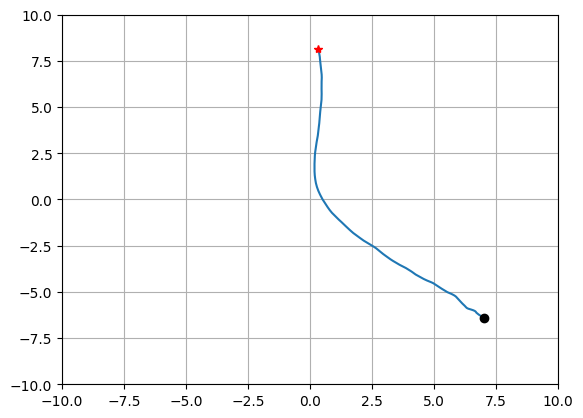

tensor(355.7951, dtype=torch.float64)

In [4]:
NegativeCharge= Particle(Mass=1.0, Charge= -1e-5)
PositiveCharge= Particle(Mass=10.0, Charge= 1e-5)
Sources = {"Particle": [NegativeCharge],
          "Position": [T.tensor([1.0, 1.0])]}
TestElectricField= ElectricField(FieldSources=Sources)
PositiveChargeInElectricField= ParticleInField(Field=TestElectricField, ChargedParticle=PositiveCharge, Target=T.tensor([0.0, 0.0]))
StateTrajectory, ActionTrajectory, Time= PositiveChargeInElectricField.SampleTrajectory(50)
Return= PositiveChargeInElectricField.TrajectoryValue(StateTrajectory, ActionTrajectory, Time)
PositiveChargeInElectricField.PlotTrajectory(StateTrajectory, Time)
Return